In [1]:
import mxnet as mx
import numpy as np
import scipy as sp
import sys
import networkx as nx
import igraph as ig
import logging
import time
import matplotlib.pyplot as plt

In [17]:
def get_act(act):
    if (act == 'sigmoid'):
        return sp.special.expit
    elif (act == 'tanh'):
        return np.tanh
    elif (act == 'relu'):
        return lambda x: np.maximum(x, 0)
    else:
        return None
    
weight_names = ['fc1_weight', 'fc2_weight']
bias_names = ['fc1_bias', 'fc2_bias']

def plot_errors(x, y):
    plt.plot(x, y)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.show()

class AutoEncoderModel:
    def __init__(self, data, num_dims, internal_act=None, output_act=None, learning_rate=0.005, batch_size=50):
        dims = [data.shape[1], num_dims, data.shape[1]]
        self.data = mx.symbol.Variable('data')
        self.y = mx.symbol.Variable('label')
        self.fc1_weight = mx.symbol.Variable(weight_names[0])
        self.fc1_bias = mx.symbol.Variable(bias_names[0])
        self.fc2_weight = mx.symbol.Variable(weight_names[1])
        self.fc2_bias = mx.symbol.Variable(bias_names[1])
        x = mx.symbol.FullyConnected(data=self.data, weight=self.fc1_weight,
                                     bias=self.fc1_bias, num_hidden=dims[1])
        if (internal_act is not None):
            x = mx.symbol.Activation(data=x, act_type=internal_act)
            print("Internal activation: " + internal_act)
        self.layer1 = x
        x = mx.symbol.FullyConnected(data=x, weight=self.fc2_weight,
                                     bias=self.fc2_bias, num_hidden=dims[2])
        if (output_act is not None):
            x = mx.symbol.Activation(data=x, act_type=output_act)
            print("Output activation: " + output_act)
        self.layer2 = x
        # TODO How about using L1/L2 regularization.
        self.loss = mx.symbol.LinearRegressionOutput(data=x, label=self.y)
        self.model = mx.mod.Module(symbol=self.loss, data_names=['data'], label_names = ['label'])
        self.init_data(data, batch_size, learning_rate)
        
        def cal_model_numpy(params):
            fc1_weight = params.get(weight_names[0]).asnumpy()
            fc1_bias = params.get(bias_names[0]).asnumpy()
            fc2_weight = params.get(weight_names[1]).asnumpy()
            fc2_bias = params.get(bias_names[1]).asnumpy()

            np_data = data.asnumpy()
            hidden = np.dot(np_data, fc1_weight.T) + fc1_bias
            act_func = get_act(internal_act)
            if (act_func is not None):
                hidden = act_func(hidden)
            output = np.dot(hidden, fc2_weight.T) + fc2_bias
            act_func = get_act(output_act)
            if (act_func is not None):
                output = act_func(output)
            return np.sum(np.square(output - np_data))

        self.numpy_cal = cal_model_numpy
        
    def init_data(self, data, batch_size=50, learning_rate=0.005):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':data},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        print("Learning rate: " + str(learning_rate))
        print("batch size: " + str(batch_size))
        # allocate memory given the input data and label shapes
        self.model.bind(data_shapes=data_iter.provide_data, label_shapes=data_iter.provide_label)
        # initialize parameters by uniform random numbers
        self.model.init_params(initializer=mx.init.Uniform(scale=.1))
        # use SGD with learning rate 0.1 to train
        self.model.init_optimizer(optimizer='sgd',
                                  optimizer_params={'learning_rate': learning_rate,
                                                    'momentum': 0.9})

    def fit_int(self, data, batch_size, num_epoch, params=None, learning_rate=0.005, reinit_opt=True):
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':data},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        
        if (params is not None):
            self.model.set_params(arg_params=params, aux_params=None, force_init=True)
            if (reinit_opt):
                print("reinit optimizer. New learning rate: " + str(learning_rate))
                self.model.init_optimizer(optimizer='sgd',
                                          optimizer_params={'learning_rate': learning_rate,
                                                            'momentum': 0.9}, force_init=True)
        # use accuracy as the metric
        metric = mx.metric.create('acc')
        # train 5 epochs, i.e. going over the data iter one pass
        for epoch in range(num_epoch):
            data_iter.reset()
            metric.reset()
            for batch in data_iter:
                self.model.forward(batch, is_train=True)       # compute predictions
                self.model.update_metric(metric, batch.label)  # accumulate prediction accuracy
                self.model.backward()                          # compute gradients
                self.model.update()                            # update parameters
            #print('Epoch %d, Training %s' % (epoch, metric.get()))

    def train(self, data, num_epoc, params = None, debug=False, return_err=False):
        print("internal #epochs: " + str(num_epoc))
        int_epoc = 100
        prev_val = None
        reinit_opt = True
        plot_xs = []
        plot_yx = []
        for i in range(num_epoc/int_epoc):
            curr = time.time()
            self.fit_int(data, self.batch_size, int_epoc, params, self.learning_rate, reinit_opt=reinit_opt)
            if (debug):
                print(str(int_epoc) + " epochs takes " + str(time.time() - curr) + " seconds")
            reinit_opt = False

            params = self.model.get_params()[0]
            val = self.numpy_cal(params)
            plot_xs.append((i + 1) * int_epoc)
            plot_yx.append(val)
            if (debug):
                print("epoc " + str((i + 1) * int_epoc) + ": " + str(val))
                sys.stdout.flush()
            if (prev_val is not None and prev_val < val):
                self.learning_rate = self.learning_rate / 2
                reinit_opt = True
            prev_val = val
        plot_errors(plot_xs, plot_yx)
        if (return_err):
            return params, plot_xs, plot_yx
        else:
            return params

In [18]:
def train(data, num_dims, num_epoc, internal_act=None, output_act=None, learning_rate=0.005, batch_size=50, debug=False, return_err=False):
    model = AutoEncoderModel(data, num_dims, internal_act, output_act, learning_rate, batch_size)
    return model.train(data, num_epoc, debug=debug, return_err=return_err)

## Run on a low-rank data

In [19]:
rand_data1 = mx.ndarray.random_uniform(shape=[1000, 10])
rand_data2 = mx.ndarray.random_uniform(shape=[10, 100])
rand_data = mx.ndarray.dot(rand_data1, rand_data2)
print("max: " + str(mx.ndarray.max(rand_data)))
rand_data = rand_data / mx.ndarray.max(rand_data)
print(rand_data.shape)

max: 
[ 5.49624777]
<NDArray 1 @cpu(0)>
(1000L, 100L)


In [20]:
np_rand_data = rand_data.asnumpy()
U, s, Vh = sp.sparse.linalg.svds(np_rand_data, k=10)
low_dim_data = np.dot(np_rand_data, Vh.T)
print(low_dim_data)
print(sum(low_dim_data[low_dim_data > 0]))
print(sum(low_dim_data[low_dim_data < 0]))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_rand_data))))

[[-0.06789682  0.11745708  0.01811091 ..., -0.22041818  0.25947556
   4.58424139]
 [ 0.06577194  0.15134373  0.12103066 ...,  0.09472218  0.52994013
   4.72747707]
 [ 0.18843757 -0.02188844  0.01198309 ..., -0.19646543  0.0452216
   3.51541185]
 ..., 
 [ 0.14157917  0.11198635 -0.05527457 ..., -0.25732851  0.19383214
   4.35923386]
 [ 0.04307616 -0.11992847 -0.01043215 ..., -0.1986502  -0.17690027
   5.00072002]
 [-0.03079219  0.05760233 -0.08055174 ...,  0.09610062 -0.04332777
   3.86204791]]
5186.59034291
-553.564527681
svd error: 1.31856e-08


Learning rate: 0.4
batch size: 100
internal #epochs: 5000


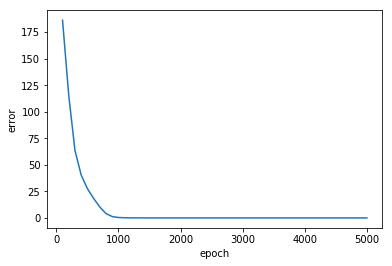

In [21]:
params_linear_r10=train(rand_data, 10, 5000, learning_rate=0.4, batch_size=100)

In [186]:
params_sigmoid_r10=train(rand_data, 10, 5000, internal_act='tanh', learning_rate=0.4, batch_size=100)

Internal activation: tanh
Learning rate: 0.4
batch size: 100
internal #epochs: 5000
100 epochs takes 1.29150795937 seconds
epoc 100: 152.982
100 epochs takes 1.27169084549 seconds
epoc 200: 135.442
100 epochs takes 1.31027507782 seconds
epoc 300: 105.656
100 epochs takes 1.30603003502 seconds
epoc 400: 74.7395
100 epochs takes 1.29361391068 seconds
epoc 500: 53.4827
100 epochs takes 1.27092599869 seconds
epoc 600: 38.1661
100 epochs takes 1.36336493492 seconds
epoc 700: 27.6645
100 epochs takes 1.35749292374 seconds
epoc 800: 20.4129
100 epochs takes 1.29214310646 seconds
epoc 900: 15.0069
100 epochs takes 1.28233599663 seconds
epoc 1000: 10.7732
100 epochs takes 1.25471997261 seconds
epoc 1100: 7.34073
100 epochs takes 1.32835412025 seconds
epoc 1200: 4.63181
100 epochs takes 1.24992394447 seconds
epoc 1300: 2.7774
100 epochs takes 1.37860703468 seconds
epoc 1400: 1.77053
100 epochs takes 1.37559890747 seconds
epoc 1500: 1.21751
100 epochs takes 1.24903512001 seconds
epoc 1600: 0.9674

## Run on real data

We compute the embedding on a graph with 81306 vertices and 1768149 vertices. To embed the graph into 10 dimensions, we start with the most densest columns and increase the number of columns to embed. When we increase the number of columns to embed, we use the parameters trained from the previous run (on the dataset with a smaller number of columns).

In [110]:
elg = nx.read_edgelist("/home/ubuntu/datasets/twitter_combined.txt")
spm = nx.to_scipy_sparse_matrix(elg, dtype='f')

In [247]:
def get_densest_idx(spm, num):
    colsum = np.ravel(spm.sum(axis=0))
    max_cols = np.sort(np.ravel(colsum), axis=None)[len(colsum) - num]
    return max_cols, colsum >= max_cols

def get_densest(spm, num):
    max_cols, idx = get_densest_idx(spm, num)
    sp_data = spm[:,idx]
    return sp_data

def get_densest2(spm, num1, num2):
    colsum = np.ravel(spm.sum(axis=1))
    sorted_colsum = np.sort(np.ravel(colsum), axis=None)
    max_cols1 = sorted_colsum[len(colsum) - num1]
    max_cols2 = sorted_colsum[len(colsum) - (num2 + num1)]
    sp_data1 = spm[:,colsum >= max_cols1]
    sp_data2 = spm[:,np.logical_and(colsum >= max_cols2, colsum < max_cols1)]
    return sp_data1, sp_data2

### Compute the embedding on the densest 10 columns.

In [200]:
sp_data10 = get_densest(spm, 10)
data10 = mx.ndarray.sparse.csr_matrix(sp_data10)
print(mx.ndarray.sum(data10, axis=0))
print(data10.shape)


[ 2490.  3383.  2484.  2758.  2476.  1789.  2133.  3011.  3239.  2155.]
<NDArray 10 @cpu(0)>
(81306L, 10L)


In [114]:
np_data10 = data10.asnumpy()
U, s, Vh = sp.linalg.svd(np_data10, full_matrices=False)
low_dim_data = np.dot(np_data10, Vh.T)
print(low_dim_data.shape)
print(np.max(low_dim_data))
print(np.min(low_dim_data))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_data10))))

(81306, 10)
1.21314
-2.3992
svd error: 6.78263e-09


In [143]:
params_linear10=train(data10, 10, 2000, internal_act=None, learning_rate=0.1, batch_size=2000)

Learning rate: 0.1
batch size: 2000
internal #epochs: 100
100 epochs takes 6.57384419441 seconds
epoc 0: 661.281
100 epochs takes 7.22010612488 seconds
epoc 100: 205.035
100 epochs takes 6.69524002075 seconds
epoc 200: 86.0281
100 epochs takes 6.86633992195 seconds
epoc 300: 69.2754
100 epochs takes 7.26551198959 seconds
epoc 400: 48.0851
100 epochs takes 7.08142089844 seconds
epoc 500: 24.3964
100 epochs takes 6.72911000252 seconds
epoc 600: 8.38904
100 epochs takes 6.66133213043 seconds
epoc 700: 2.06232
100 epochs takes 6.76626992226 seconds
epoc 800: 0.410246
100 epochs takes 7.24766898155 seconds
epoc 900: 0.0735736
100 epochs takes 6.81751203537 seconds
epoc 1000: 0.0125639
100 epochs takes 7.10305809975 seconds
epoc 1100: 0.00211213
100 epochs takes 7.08962607384 seconds
epoc 1200: 0.00035564
100 epochs takes 6.72433185577 seconds
epoc 1300: 6.57533e-05
100 epochs takes 6.78700900078 seconds
epoc 1400: 1.69345e-05
100 epochs takes 6.82878088951 seconds
epoc 1500: 1.13987e-05
100

In [140]:
params_sigmoid10=train(data10, 10, 10000, internal_act='tanh', learning_rate=0.1, batch_size=2000)

Internal activation: tanh
Learning rate: 0.1
batch size: 2000
internal #epochs: 100
100 epochs takes 8.79215788841 seconds
epoc 0: 782.973
100 epochs takes 8.54049897194 seconds
epoc 100: 365.227
100 epochs takes 8.9551320076 seconds
epoc 200: 177.58
100 epochs takes 8.56133294106 seconds
epoc 300: 121.924
100 epochs takes 8.85677790642 seconds
epoc 400: 115.84
100 epochs takes 8.66231513023 seconds
epoc 500: 110.476
100 epochs takes 8.81901407242 seconds
epoc 600: 102.967
100 epochs takes 9.03215098381 seconds
epoc 700: 91.0163
100 epochs takes 8.80674505234 seconds
epoc 800: 72.9704
100 epochs takes 8.79361891747 seconds
epoc 900: 51.2826
100 epochs takes 8.95192408562 seconds
epoc 1000: 33.1414
100 epochs takes 8.9709789753 seconds
epoc 1100: 22.8834
100 epochs takes 8.84673404694 seconds
epoc 1200: 18.4841
100 epochs takes 9.01217198372 seconds
epoc 1300: 16.636
100 epochs takes 8.86660695076 seconds
epoc 1400: 15.6374
100 epochs takes 8.89191913605 seconds
epoc 1500: 14.9088
100 e

In [141]:
params_sigmoid10=train(data10, 10, 10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 100
100 epochs takes 11.51684618 seconds
epoc 0: 9111.85
100 epochs takes 11.5236680508 seconds
epoc 100: 2590.8
100 epochs takes 11.5863921642 seconds
epoc 200: 1321.07
100 epochs takes 11.642277956 seconds
epoc 300: 901.515
100 epochs takes 11.6188299656 seconds
epoc 400: 730.788
100 epochs takes 11.588654995 seconds
epoc 500: 637.645
100 epochs takes 11.7546470165 seconds
epoc 600: 576.195
100 epochs takes 11.7699801922 seconds
epoc 700: 528.786
100 epochs takes 11.7428228855 seconds
epoc 800: 484.707
100 epochs takes 12.0463659763 seconds
epoc 900: 430.7
100 epochs takes 11.7655608654 seconds
epoc 1000: 365.675
100 epochs takes 11.9206221104 seconds
epoc 1100: 311.159
100 epochs takes 11.8484351635 seconds
epoc 1200: 272.315
100 epochs takes 11.7809638977 seconds
epoc 1300: 245.158
100 epochs takes 11.9608340263 seconds
epoc 1400: 225.124
100 epochs takes 11.8433690071 seconds

### Compute the embedding on the densest 30 columns

In [201]:
sp_data30 = get_densest(spm, 30)
data30 = mx.ndarray.sparse.csr_matrix(sp_data30)
print(mx.ndarray.sum(data30, axis=0))
print(data30.shape)


[ 1256.  1377.  1467.  1251.  1521.  1229.  2490.  1695.  1291.  1387.
  1275.  1743.  1443.  1497.  3383.  2484.  2758.  1666.  1255.  2476.
  1789.  1358.  1269.  1395.  2133.  3011.  3239.  1568.  2155.  1509.]
<NDArray 30 @cpu(0)>
(81306L, 30L)


In [204]:
U, s, Vh = sp.sparse.linalg.svds(sp_data30, k=15)
res = np.dot(sp_data30.dot(Vh.T), Vh)
print("svd error: " + str(np.sum(np.square(res - sp_data30))))

svd error: 12539.0


In [270]:
params_sigmoid30=train(data30, num_dims=15, num_epoc=5000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 5000
100 epochs takes 20.6709759235 seconds
epoc 100: 48314.7
100 epochs takes 20.4837198257 seconds
epoc 200: 38406.1
100 epochs takes 20.5601148605 seconds
epoc 300: 34322.2
100 epochs takes 20.5915081501 seconds
epoc 400: 30803.0
100 epochs takes 20.6268348694 seconds
epoc 500: 27163.7
100 epochs takes 20.582613945 seconds
epoc 600: 24936.0
100 epochs takes 20.5398068428 seconds
epoc 700: 23276.2
100 epochs takes 20.6115128994 seconds
epoc 800: 21595.4
100 epochs takes 20.6879820824 seconds
epoc 900: 19896.2
100 epochs takes 20.4795188904 seconds
epoc 1000: 18392.6
100 epochs takes 20.4407179356 seconds
epoc 1100: 16991.6
100 epochs takes 20.6663501263 seconds
epoc 1200: 15279.4
100 epochs takes 20.5412111282 seconds
epoc 1300: 13563.2
100 epochs takes 20.3222379684 seconds
epoc 1400: 12011.7
100 epochs takes 20.4241900444 seconds
epoc 1500: 10697.8
100 epochs takes 20.32267594

### Compute the embedding on the densest 100 columns.

In [202]:
sp_data100 = get_densest(spm, 100)
data100 = mx.ndarray.sparse.csr_matrix(sp_data100)
print(mx.ndarray.sum(data100, axis=0))
print(data100.shape)


[ 1256.   923.  1180.   802.   979.   744.   948.   837.  1377.  1183.
  1023.  1467.   748.  1251.  1198.   921.   818.   777.   889.  1185.
  1521.   744.  1229.   916.   810.   804.   844.  1051.   861.   991.
   784.  1225.  2490.   975.   915.   996.  1030.   822.   806.   756.
  1695.   780.  1053.   964.  1291.  1103.  1091.  1387.  1275.   889.
   828.  1743.  1443.   959.  1497.  3383.   798.   756.  1080.   937.
   758.  2484.   879.   849.   766.   737.  2758.   733.   788.   878.
  1666.   857.  1079.   902.   783.  1255.  2476.   780.  1789.  1054.
   932.  1358.  1269.  1161.   765.   912.   818.  1220.  1395.  1009.
   801.  2133.  3011.  3239.  1568.  2155.  1072.  1509.  1226.   779.]
<NDArray 100 @cpu(0)>
(81306L, 100L)


We want to start with SVD and see how well it performs.

In [190]:
U, s, Vh = sp.sparse.linalg.svds(sp_data100, k=30)
res = np.dot(sp_data100.dot(Vh.T), Vh)
print("svd error: " + str(np.sum(np.square(res - sp_data100))))

svd error: 42371.5


With curriculum learning, we can take advantage of the computation results from the denser columns.
To some extent, curriculum learning provides a new way of initializing the parameters of a neural network. We take the parameters from the neural network trained for the denser columns of a graph to initialize the neural network for the dataset with more columns.

The functions below expand and shrink the weight matrices for the smaller or the larger neural networks.

In [290]:
# Extend the weight matrices in the encoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_encode(weight, bias, idx, num_inputs, num_outputs, rand_init):
    if (rand_init):
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    else:
        out_weight = np.zeros((num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[0:weight.shape[0], idx] = weight.asnumpy()
    out_bias[0:bias.shape[0]] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Extend the weight matrices in the decoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_decode(weight, bias, idx, num_inputs, num_outputs, rand_init):
    if (rand_init):
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    else:
        out_weight = np.zeros((num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[idx, 0:weight.shape[1]] = weight.asnumpy()
    out_bias[idx] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Shrink the weight matrices in the encoder of the larger autoencoder to
# the shape required by the smaller autoencoder. This operation is
# the reverse of extend_params_encode.
def shrink_params_encode(weight, bias, idx, num_inputs, num_outputs):
    weight = weight.asnumpy()
    bias = bias.asnumpy()
    return mx.nd.array(weight[0:num_outputs, idx]), mx.nd.array(bias[0:num_outputs])

# Shrink the weight matrices in the decoder of the larger autoencoder to
# the shape required by the smaller autoencoder. This operation is
# the reverse of extend_params_decode.
def shrink_params_decode(weight, bias, idx, num_inputs, num_outputs):
    weight = weight.asnumpy()
    bias = bias.asnumpy()
    return mx.nd.array(weight[idx, 0:num_inputs]), mx.nd.array(bias[idx])

# This function extends the parameter matrices in the small autoencoder
# to an autoencoder with the specified number of input nodes and hidden nodes.
def extend_params(params, new_data, new_hidden, rand_init=False):
    old_inputs = params.get(weight_names[0]).shape[1]
    old_hidden = params.get(bias_names[0]).shape[0]
    new_inputs = new_data.shape[1]
    max_cols, max_idx = get_densest_idx(new_data, old_inputs)
    weight, bias = extend_params_encode(params.get(weight_names[0]),
                                        params.get(bias_names[0]), max_idx,
                                        new_inputs, new_hidden, rand_init)
    new_params = {}
    new_params.update({weight_names[0]: weight})
    new_params.update({bias_names[0]: bias})
    weight, bias = extend_params_decode(params.get(weight_names[1]),
                                        params.get(bias_names[1]), max_idx,
                                        new_hidden, new_inputs, rand_init)
    new_params.update({weight_names[1]: weight})
    new_params.update({bias_names[1]: bias})
    return new_params

The code in this section is to verify the implementation of the functions above work correctly.

In [292]:
def cal_model_numpy(data, params, selected_cols=None, internal_act=None, output_act=None):
    fc1_weight = params.get(weight_names[0]).asnumpy()
    fc1_bias = params.get(bias_names[0]).asnumpy()
    fc2_weight = params.get(weight_names[1]).asnumpy()
    fc2_bias = params.get(bias_names[1]).asnumpy()

    np_data = data.asnumpy()
    hidden = np.dot(np_data, fc1_weight.T) + fc1_bias
    act_func = get_act(internal_act)
    if (act_func is not None):
        hidden = act_func(hidden)
    output = np.dot(hidden, fc2_weight.T) + fc2_bias
    act_func = get_act(output_act)
    if (act_func is not None):
        output = act_func(output)
    if (selected_cols is None):
        return np.sum(np.square(output - np_data))
    else:
        return np.sum(np.square(output[:,selected_cols] - np_data[:,selected_cols]))

tmp30 = params_sigmoid30
tmp100 = extend_params(tmp30, sp_data100, 30, rand_init=False)
max_cols30, max_idx30 = get_densest_idx(sp_data100, 30)
print(cal_model_numpy(data30, tmp30, internal_act='tanh', output_act='sigmoid'))
print(cal_model_numpy(data100, tmp100, selected_cols=max_idx30, internal_act='tanh', output_act='sigmoid'))

old inputs: 30
old hidden: 15
new inputs: 100
2589.55
2589.55


Here we use the parameters from the smaller autoencoder to initialize the parameters in the larger autoencoder.

In [281]:
params_sigmoid100_init = extend_params(params_sigmoid30, sp_data100, 30, rand_init=True)
model = AutoEncoderModel(data100, 30, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)
params_sigmoid100 = model.train(data100, num_epoc=5000, params=params_sigmoid100_init)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 5000
reinit optimizer. New learning rate: 0.2
100 epochs takes 49.9413859844 seconds
epoc 100: 65572.6
100 epochs takes 50.3041770458 seconds
epoc 200: 60734.8
100 epochs takes 50.5001418591 seconds
epoc 300: 58643.4
100 epochs takes 50.1831459999 seconds
epoc 400: 57395.7
100 epochs takes 50.1922550201 seconds
epoc 500: 56486.5
100 epochs takes 50.0525450706 seconds
epoc 600: 55708.6
100 epochs takes 49.9641830921 seconds
epoc 700: 54969.4
100 epochs takes 50.0099928379 seconds
epoc 800: 54234.4
100 epochs takes 50.0637071133 seconds
epoc 900: 53498.1
100 epochs takes 50.0675020218 seconds
epoc 1000: 52764.2
100 epochs takes 49.951611042 seconds
epoc 1100: 52038.1
100 epochs takes 50.3725850582 seconds
epoc 1200: 51327.1
100 epochs takes 50.0172758102 seconds
epoc 1300: 50640.2
100 epochs takes 50.3492980003 seconds
epoc 1400: 49986.9
100 epochs takes 50.255428791 seconds
epoc 15

In [282]:
params_sigmoid100_2 = model.train(data100, num_epoc=5000, params=params_sigmoid100)

internal #epochs: 5000
reinit optimizer. New learning rate: 0.2
100 epochs takes 49.8752069473 seconds
epoc 100: 29111.8
100 epochs takes 49.6204049587 seconds
epoc 200: 28630.2
100 epochs takes 49.497205019 seconds
epoc 300: 28165.3
100 epochs takes 49.4390890598 seconds
epoc 400: 27714.1
100 epochs takes 49.4647581577 seconds
epoc 500: 27273.9
100 epochs takes 49.4208300114 seconds
epoc 600: 26841.9
100 epochs takes 49.414003849 seconds
epoc 700: 26415.7
100 epochs takes 49.3721160889 seconds
epoc 800: 25993.1
100 epochs takes 49.5414528847 seconds
epoc 900: 25572.0
100 epochs takes 49.5266869068 seconds
epoc 1000: 25151.0
100 epochs takes 49.6930439472 seconds
epoc 1100: 24729.8
100 epochs takes 49.8241529465 seconds
epoc 1200: 24309.3
100 epochs takes 49.9031429291 seconds
epoc 1300: 23892.1
100 epochs takes 50.006289959 seconds
epoc 1400: 23481.1
100 epochs takes 49.9422609806 seconds
epoc 1500: 23078.3
100 epochs takes 49.8204278946 seconds
epoc 1600: 22684.4
100 epochs takes 49.

In [284]:
params_sigmoid100_orig=train(data100, num_dims=30, num_epoc=10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 10000
100 epochs takes 50.0786571503 seconds
epoc 100: 117194.0
100 epochs takes 50.4721970558 seconds
epoc 200: 115469.0
100 epochs takes 50.4774711132 seconds
epoc 300: 106096.0
100 epochs takes 50.3924469948 seconds
epoc 400: 96626.0
100 epochs takes 50.4311208725 seconds
epoc 500: 93401.9
100 epochs takes 50.3713068962 seconds
epoc 600: 91831.9
100 epochs takes 50.5239970684 seconds
epoc 700: 90197.9
100 epochs takes 50.5635919571 seconds
epoc 800: 88247.8
100 epochs takes 50.560598135 seconds
epoc 900: 86554.8
100 epochs takes 50.1708669662 seconds
epoc 1000: 85147.5
100 epochs takes 50.513051033 seconds
epoc 1100: 83771.5
100 epochs takes 50.6233348846 seconds
epoc 1200: 82242.6
100 epochs takes 50.5886049271 seconds
epoc 1300: 80421.5
100 epochs takes 50.6030488014 seconds
epoc 1400: 78234.4
100 epochs takes 50.5480351448 seconds
epoc 1500: 75972.2
100 epochs takes 50.63163

### Compute the embedding on the densest 1000 columns.

In [152]:
sp_data1000 = get_densest(spm, 1000)
data1000 = mx.ndarray.sparse.csr_matrix(sp_data1000)
print(mx.ndarray.sum(data1000, axis=0))
print(data1000.shape)


[ 571.  319.  282. ...,  484.  304.  330.]
<NDArray 1004 @cpu(0)>
(81306L, 1004L)


In [153]:
U, s, Vh = sp.sparse.linalg.svds(sp_data1000, k=100)
res = np.dot(sp_data1000.dot(Vh.T), Vh)
print("svd error: " + str(np.sum(np.square(res - sp_data1000))))

svd error: 203856.0


In [295]:
params_sigmoid1000_init = extend_params(params_sigmoid100, sp_data1000, 100, rand_init=True)
model = AutoEncoderModel(data1000, num_dims=100, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)
params_sigmoid1000 = model.train(data1000, num_epoc=10000, params=params_sigmoid1000_init)

old inputs: 100
old hidden: 30
new inputs: 1004
Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 10000
reinit optimizer. New learning rate: 0.2
100 epochs takes 432.728415012 seconds
epoc 100: 494267.0
100 epochs takes 432.248641968 seconds
epoc 200: 425895.0
100 epochs takes 429.028847933 seconds
epoc 300: 397958.0
100 epochs takes 431.694869995 seconds
epoc 400: 381204.0
100 epochs takes 428.774977922 seconds
epoc 500: 370016.0
100 epochs takes 435.297715902 seconds
epoc 600: 361989.0
100 epochs takes 432.369880199 seconds
epoc 700: 355645.0
100 epochs takes 432.517203093 seconds
epoc 800: 350544.0
100 epochs takes 432.737567902 seconds
epoc 900: 346421.0
100 epochs takes 431.994055033 seconds
epoc 1000: 342977.0
100 epochs takes 433.733255863 seconds
epoc 1100: 339984.0
100 epochs takes 434.355044842 seconds
epoc 1200: 337325.0
100 epochs takes 432.226321936 seconds
epoc 1300: 334932.0
100 epochs takes 434.114796877 seconds
e

In [294]:
params_sigmoid1000=train(data1000, num_dims=100, num_epoc=10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 10000
100 epochs takes 431.080384016 seconds
epoc 100: 508423.0
100 epochs takes 431.098898172 seconds
epoc 200: 460172.0
100 epochs takes 430.493998051 seconds
epoc 300: 447464.0
100 epochs takes 430.86473608 seconds
epoc 400: 441789.0
100 epochs takes 429.94924593 seconds
epoc 500: 438611.0
100 epochs takes 431.865408182 seconds
epoc 600: 436578.0
100 epochs takes 434.106994867 seconds
epoc 700: 435149.0
100 epochs takes 433.679186821 seconds
epoc 800: 434061.0
100 epochs takes 433.638868093 seconds
epoc 900: 433171.0
100 epochs takes 432.451326847 seconds
epoc 1000: 432383.0
100 epochs takes 436.009906054 seconds
epoc 1100: 431612.0
100 epochs takes 433.658218861 seconds
epoc 1200: 430779.0
100 epochs takes 432.428790092 seconds
epoc 1300: 429789.0
100 epochs takes 435.449054956 seconds
epoc 1400: 428567.0
100 epochs takes 434.815099001 seconds
epoc 1500: 427132.0
100 epochs ta

In [ ]:
data1000 = mx.ndarray.sparse.csr_matrix(sp_data1000)
print(mx.ndarray.sum(data1000, axis=0))
print(data1000.shape)

In [ ]:
pref_matrix = [[0.9, 0.1], [0.1, 0.9]]
block_sizes = [70, 30]
g = ig.Graph.SBM(100, pref_matrix, block_sizes, directed=True)
sim_spm = g.get_adjacency()